# ARPA Weather Station Data
This notebook is used for:
1) testing ARPA API functionalities
2) testing functions to be implemented in the plugin
3) testing libraries to be used and evaluate performances

First, it is necessary to get a token.
Go to Open Data Lombardia website (https://dati.lombardia.it/). Subscribe to the website and go to your profile settings. <br>
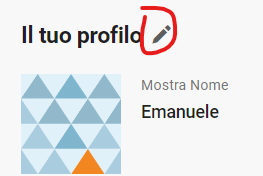 <br>
Modify your profile and open the "Opzioni per lo sviluppatore" tab. Create a new App Token to be used.


Useful notebook for Sodapy: https://github.com/xmunoz/sodapy/blob/master/examples/soql_queries.py

# TO-DO
- put functions in a separaty .py file
- use widgets?

## Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

from sodapy import Socrata
import pandas as pd
from datetime import datetime, timedelta
import requests
from io import BytesIO
from zipfile import ZipFile
import os
import time
import numpy as np

import dask.dataframe as dd

## Client

In [2]:
arpa_token = "riTLzYVRVdDaQtUkxDDaHRgJi" 
#arpa_token = "" 
print(arpa_token)

riTLzYVRVdDaQtUkxDDaHRgJi


In [3]:
def order_dates(df):
    df = df.sort_values(by='data', ascending=True).reset_index(drop=True)
    return df

Pandas va installato anche se si installa prima Dask

Function to create a client session with the API using the token:

Make a function that also tests if token is valid:

In [4]:
def connect_ARPA_api(token: str) -> Socrata:
    """
    Function to connect to ARPA API.

    Parameters:
        token (str): the ARPA token obtained from Open Data Lombardia website

    Returns:
        client: client session
    """
    # Connect to Open Data Lombardia using the token
    if token == "":
        print("No token provided. Requests made without an app_token will be subject to strict throttling limits.")
        client = Socrata("www.dati.lombardia.it", None)
    else:
        print("Using provided token.")
        client = Socrata("www.dati.lombardia.it", app_token=token)

    return client

Import the code of the dataset. In this case "nf78-nj6b" is related to ARPA stations information containing:
1) sensors id
2) sensor type
3) unit
4) stations id
5) stations names
...

## Stations and sensors information

MAKE A FUNCTION THAT CONNECTS WITH TOKEN IF THAT IS PROVIDED

In [5]:
stationsId = "nf78-nj6b" # Select meteo stations dataset containing positions and information about sensors
client = connect_ARPA_api(arpa_token)
sensors_info = client.get_all(stationsId)

Using provided token.


Create sensors dataframe:

In [6]:
def ARPA_sensors_info(sensors_info: dict) -> pd.DataFrame:
    """
    Functions to convert sensors information to Pandas dataframe and fix the data types.

    Parameters:
        sensors_info: object obtained from Socrata with get request

    Returns:
        df: dataframe containing ARPA sensors information
    """
    sensors_df = pd.DataFrame(sensors_info)
    sensors_df["idsensore"] = sensors_df["idsensore"].astype("int32")
    sensors_df["tipologia"] = sensors_df["tipologia"].astype("category")
    sensors_df["idstazione"] = sensors_df["idstazione"].astype("int32")
    sensors_df["quota"] = sensors_df["quota"].astype("int16")
    sensors_df["provincia"] = sensors_df["provincia"].astype("category")
    sensors_df["storico"] = sensors_df["storico"].astype("category")
    sensors_df["datastart"] = pd.to_datetime(sensors_df["datastart"])
    sensors_df["datastop"] = pd.to_datetime(sensors_df["datastop"])
    sensors_df = sensors_df.drop(columns=[":@computed_region_6hky_swhk", ":@computed_region_ttgh_9sm5"])

    return sensors_df


In [7]:
sensors_df = ARPA_sensors_info(sensors_info)
sensors_df

,idsensore,tipologia,unit_dimisura,idstazione,nomestazione,quota,provincia,datastart,storico,cgb_nord,cgb_est,lng,lat,location,datastop
0,10373,Precipitazione,mm,687,Ferno v.Di Dio,215,VA,2007-08-13,N,5051773,481053,8.756970445453431,45.61924377994763,"{'latitude': '45.61924377994763', 'longitude':...",NaT
1,10376,Precipitazione,mm,706,Lecco v.Sora,272,LC,2008-07-22,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",NaT
2,10377,Temperatura,°C,706,Lecco v.Sora,272,LC,2008-07-22,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",NaT
3,10381,Umidità Relativa,%,706,Lecco v.Sora,272,LC,2008-07-22,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",NaT
4,10382,Radiazione Globale,W/m²,706,Lecco v.Sora,272,LC,2008-07-31,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,9869,Umidità Relativa,%,672,Cornale v.Libertà,74,PV,2005-07-28,N,4987406,493238,8.914144599002409,45.04007657202963,"{'latitude': '45.04007657202963', 'longitude':...",NaT
1228,9933,Precipitazione,mm,677,Cremona Via Fatebenefratelli,43,CR,2006-04-10,N,4999315,582066,10.043836158369393,45.14254063221695,"{'latitude': '45.14254063221695', 'longitude':...",NaT
1229,9935,Radiazione Globale,W/m²,677,Cremona Via Fatebenefratelli,43,CR,2006-04-10,N,4999315,582066,10.043836158369393,45.14254063221695,"{'latitude': '45.14254063221695', 'longitude':...",NaT
1230,9938,Temperatura,°C,677,Cremona Via Fatebenefratelli,43,CR,2006-04-10,N,4999315,582066,10.043836158369393,45.14254063221695,"{'latitude': '45.14254063221695', 'longitude':...",NaT


In [8]:
unique_sensors_list = sensors_df['tipologia'].unique()
unique_sensors_list

['Precipitazione', 'Temperatura', 'Umidità Relativa', 'Radiazione Globale', 'Direzione Vento', 'Velocità Vento', 'Livello Idrometrico', 'Altezza Neve']
Categories (8, object): ['Altezza Neve', 'Direzione Vento', 'Livello Idrometrico', 'Precipitazione', 'Radiazione Globale', 'Temperatura', 'Umidità Relativa', 'Velocità Vento']

Select the sensor type:

In [9]:
sensor_sel = "Temperatura"

In [10]:
sensors_list = (sensors_df.loc[sensors_df['tipologia'] == sensor_sel]).idsensore.tolist()  #& (sensors_df['storico'] == storic_data)
sensors_list_str = list(map(str, sensors_list))

In [11]:
# #Check sensori storici
# sensors_df.loc[sensors_df['storico'] == 'S']

Consideration: inside the plugin the data type for each columns must be set accordingly to QGIS data types.

Select sensor type and create a list of those sensors from the previous dataframe.

In [12]:
print(("Selected sensor: {sel}").format(sel=sensor_sel))
print(("Number of selected sensor: {sens_len}").format(sens_len=len(sensors_list)))

Selected sensor: Temperatura
Number of selected sensor: 248


## Define Dates

In [13]:
def check_dates(start_date, end_date):
    """
    Check that the start and end dates are in the same year.
    
    Parameters:
        start_date (str): The start date in the format "YYYY-MM-DD".
        end_date (str): The end date in the format "YYYY-MM-DD".
    
    Returns:
        year (int): The year of the start and end dates.
        start_datetime (datetime): The start date as a datetime object.
        end_datetime (datetime): The end date as a datetime object.
        
    Raises:
        Exception: If the start and end dates are not in the same year.
    """
    
    # Convert the start and end dates from strings to datetime objects
    start_datetime = datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S")
    end_datetime = datetime.strptime(end_date, "%Y-%m-%d %H:%M:%S")

    # Check that the start and end dates are in the same year
    if start_datetime.year != end_datetime.year:
        raise Exception("Dates must be in the same year! Years chosen are: {year_start} and {year_end}".format(
            year_start=start_datetime.year, year_end=end_datetime.year
        ))

    # Get the year of the start and end dates
    year = start_datetime.year
    
    return year, start_datetime, end_datetime

In [14]:
start_date_str = "2017-01-01 00:00:00"
end_date_str = "2017-12-31 23:50:00"

year, start_date, end_date = check_dates(start_date_str, end_date_str)
year, start_date, end_date

(2017,
 datetime.datetime(2017, 1, 1, 0, 0),
 datetime.datetime(2017, 12, 31, 23, 50))

----

## API Time series
This part requires time series and relative information from the API. The output of this section is to obtain a dataframe that has the same characteristics as the dataframe obtained from the csv processing.

Following function is used to obtain minimum and maximum date available in ARPA API.

In [15]:
def req_ARPA_start_end_date_API(client):
    """
    Function to request the start and the end date of data available in the ARPA API.

        Parameters:
            client: the client session

        Returns: 
            start_API_date (str): starting date for available data inside the API.
            end_API_date (str): ending date for available data inside the API.
        
    """
    
    #Weather sensors dataset id on Open Data Lombardia
    weather_sensor_id = "647i-nhxk"
    
    #Query
    query = """ select MAX(data), MIN(data) limit 9999999999999999"""

    #Get max and min dates from the list
    min_max_dates = client.get(weather_sensor_id, query=query)[0]
    
    #Start and minimum dates from the dict obtained from the API
    start_API_date = min_max_dates['MIN_data']
    end_API_date = min_max_dates['MAX_data']
    
    #Convert to datetime and add 1 day to end date to consider all the values inside the last day (e.g. 20/01/2023 23:10:00 won't be considered and the requested data will be untile 20/01/2023 00:00:00)
    start_API_date = datetime.strptime(start_API_date, "%Y-%m-%dT%H:%M:%S.%f")
    end_API_date = datetime.strptime(end_API_date, "%Y-%m-%dT%H:%M:%S.%f")
    
    print("The data from the API are available from: " ,start_API_date, " up to: ", end_API_date, ". Select data in this range.")

    return start_API_date, end_API_date

In [16]:
start_date_API, end_date_API = req_ARPA_start_end_date_API(client)

The data from the API are available from:  2023-01-01 00:00:00  up to:  2023-01-29 17:50:00 . Select data in this range.


Request data from API :

In [17]:
def req_ARPA_data_API(client, start_date, end_date, sensors_list):
    """
    Function to request data from available weather sensors in the ARPA API using a query.

        Parameters:
            client: the client session
            start date (str): the start date in yyy-mm-dd format
            end date (str): the end date in yyy-mm-dd format

        Returns: 
            time_series: time series of values requested with the query for all sensors
        
    """
    
    #Select the Open Data Lombardia Meteo sensors dataset
    weather_sensor_id = "647i-nhxk"
    
    #Convert to string in year-month-day format, accepted by ARPA query
    start_date = start_date.strftime("%Y-%m-%dT%H:%M:%S.%f")
    end_date = end_date.strftime("%Y-%m-%dT%H:%M:%S.%f")
    
    print("--- Starting request to ARPA API ---")
    
    t = time.time()
    
    #Query data
    query = """
      select
          *
      where data >= \'{}\' and data <= \'{}\' limit 9999999999999999
      """.format(start_date, end_date)

    #Get time series and evaluate time spent to request them
    time_series = client.get(weather_sensor_id, query=query)
    print(time_series)
    elapsed = time.time() - t
    print("Time used for requesting the data from ARPA API: ", elapsed)
    
    #Create dataframe
    df = pd.DataFrame(time_series, columns=['idsensore','data','valore'])
    
    #Convert types
    df['valore'] = df['valore'].astype('float32')
    df['idsensore'] = df['idsensore'].astype('int32')
    df['data'] = pd.to_datetime(df['data'])
    df = df.sort_values(by='data', ascending=True).reset_index(drop=True)
    
    #Filter with selected sensors list
    df = df[df['value'] != -9999]
    df = df[df['idsensore'].isin(sensors_list)]

    return df

---

## Download csv files
The output of this sections is a dataframe that has the same characteristics of the time series obtained with the API.

In [18]:
def download_extract_csv_from_year(year):
    """
    Function for selecting the correct link for downloading zipped .csv meteorological data from ARPA sensors and extracting it.

    For older data it is necessary to download this .csv files containing the time series of the meteorological sensors.

        Parameters:
            year(str): the selected year for downloading the .csv file containing the meteorological sensors time series

        Returns:
            None
    """
    
    #Create a dict with years and link to the zip folder on Open Data Lombardia - REQUIRES TO BE UPDATED EVERY YEAR
    switcher = {
        '2022': "https://www.dati.lombardia.it/download/mvvc-nmzv/application%2Fzip",
        '2021': "https://www.dati.lombardia.it/download/49n9-866s/application%2Fzip",
        '2020': "https://www.dati.lombardia.it/download/erjn-istm/application%2Fzip",
        '2019': "https://www.dati.lombardia.it/download/wrhf-6ztd/application%2Fzip",
        '2018': "https://www.dati.lombardia.it/download/sfbe-yqe8/application%2Fzip",
        '2017': "https://www.dati.lombardia.it/download/vx6g-atiu/application%2Fzip"
    }
    
    #Select the url and make request
    url = switcher[year]
    filename = 'meteo_'+str(year)+'.zip'
    
    #If yrar.csv file is already downloaded, skip download
    if not os.path.exists(year+".csv"):
        print("--- Starting download ---")
        print(('Downloading {filename} -> Started. It might take a while... Please wait!').format(filename = filename))
        req = requests.get(url)

        # Writing the file to the local file system
        with open(filename,'wb') as output_file:
            output_file.write(req.content)
        print(('Downloading {filename} -> Completed').format(filename = filename))

        print(("Starting unzipping: {filename}").format(filename=filename))
        #Loading the .zip and creating a zip object
        with ZipFile(filename, 'r') as zObject:
            # Extracting all the members of the zip into a specific location
            zObject.extractall()

        csv_file=str(year)+'.csv'
        print(("File unzipped: {filename}").format(filename=filename))
        print(("File csv saved: {filename}").format(filename=csv_file))

        #Remove the zip folder
        if os.path.exists(filename):
            print(("{filename} removed").format(filename=filename))
            os.remove(filename)
        else:
            print(("The file {filename} does not exist in this folder").format(filename=filename))
    
    else:
        print(year+".csv already exists. It won't be downloaded.")

In [19]:
def process_ARPA_csv(csv_file, start_date, end_date, sensors_list):
    """
    This function reads the ARPA csv file into a dask dataframe and provided a computed dataframe. It renames the columns like the API columns names, filters between provided dates and select the sensors present in the list.

        Parameters:
            csv_file(str): name of the csv file
            start_date(datetime): start date for processing
            end_date(datetime): end date for processing
            sensors_list(string list): list of selected sensors

        Returns:
            df(dataframe): computed filtered dask dataframe
    """
    
    print("--- Starting processing csv data ---")
    print(("The time range used for the processing is {start_date} to {end_date}").format(start_date=start_date,end_date=end_date))
    
    #Read csv file with Dask dataframe
    df = dd.read_csv(csv_file, usecols=['IdSensore','Data','Valore']) 
    
    #Make csv columns names equal to API columns names
    df = df.rename(columns={'IdSensore': 'idsensore', 'Data': 'data', 'Valore': 'valore'})
    
    #Type formatting
    df['valore'] = df['valore'].astype('float32')
    df['idsensore'] = df['idsensore'].astype('int32')
    df['data'] = dd.to_datetime(df.data, format='%d/%m/%Y %H:%M:%S')
    
    #Filter using the dates
    df = df[df['valore'] != -9999]
    df = df.loc[(df['data'] >= start_date) & (df['data'] <= end_date)]
    #Filter on temperature sensors list
    sensors_list = list(map(int, sensors_list))
    df = df[df['idsensore'].isin(sensors_list)]
    
    #Order dates
    df = df.sort_values(by='data', ascending=True).reset_index(drop=True)
    
    print("Starting computing dataframe")
    
    #Compute df
    t = time.time()
    df = df.compute()
    elapsed = time.time() - t
    print("Time used for computing dataframe: ", elapsed)
    
    return df 

In [20]:
#If the chosen start date is before the start date available in the API -> use csv data
if start_date < start_date_API:
    sensors_values = download_extract_csv_from_year(str(year))
    csv_file = str(year)+'.csv'
    sensors_values = process_ARPA_csv(csv_file, start_date, end_date, sensors_list)
    
#If the chosen start date is equal or after the start date of API -> request data from API
elif start_date >= start_date_API:
    print("Using API values")
    sensors_values = req_ARPA_data_API(client, start_date, end_date, sensors_list)

2017.csv already exists. It won't be downloaded.
--- Starting processing csv data ---
The time range used for the processing is 2017-01-01 00:00:00 to 2017-12-31 23:50:00
Starting computing dataframe
Time used for computing dataframe:  12.564006805419922


In [21]:
sensors_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9472609 entries, 0 to 325306
Data columns (total 3 columns):
 #   Column     Dtype         
---  ------     -----         
 0   idsensore  int32         
 1   data       datetime64[ns]
 2   valore     float32       
dtypes: datetime64[ns](1), float32(1), int32(1)
memory usage: 216.8 MB


## Filter values

Define functions for filtering:
- zscore
- 3 times std
- iqr

PUT APPLY FOR ZSCORE

In [22]:
def outlier_filter_iqr(df):
    """
    Function for iltering using quantiles
    
        Parameters:
            df (dataframe): ARPA dataframe containing at least the following columns: "idsensore"(int), "data"(datetime) and "valore"(float)
            sensors_list (int list): list of sensors

        Returns:
            df(dataframe): filtered dataframe using IQR
    
    """
    
    Q1 = df['valore'].quantile(0.25)
    Q3 = df['valore'].quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df['valore'] < (Q1 - 1.5 * IQR)) | (df['valore'] > (Q3 + 1.5 * IQR)))]

In [23]:
def outlier_filter_zscore(df, sensors_list, threshold=3):
    """
    Filter dataframe using Z-Score method

        Parameters:
            df (pandas.DataFrame): ARPA dataframe with columns "idsensore" (int), "data" (datetime), and "valore" (float)
            sensors_list (list of ints): list of sensor ids
            threshold (float, optional): Z-Score threshold to use for filtering, default is 3

        Returns:
            pandas.DataFrame: filtered dataframe using Z-Score method
        
    """
    filtered_df = pd.DataFrame(columns=df.columns)
    
    for sensor in sensors_list:
        sensor_df = df[df['idsensore'] == sensor]
        mean = sensor_df['valore'].mean()
        std = sensor_df['valore'].std()
        z = (sensor_df['valore'] - mean) / std
        sensor_df = sensor_df[(z.abs() < threshold)]
        filtered_df = pd.concat([filtered_df, sensor_df], ignore_index=True)
        
    return filtered_df

In [24]:
#use 'iqr' if you want to filter
#implement zscore
filter_choice = 'zscore'+'iqr'

if filter_choice == 'iqr':
    sensors_values = sensors_values.groupby('idsensore').apply(outlier_filter_iqr)
if filter_choice == 'zscore':
    sensors_values = outlier_filter_zscore(sensors_values, sensors_list)
if filter_choice == 'zscore'+'iqr':
    sensors_values = sensors_values.groupby('idsensore').apply(outlier_filter_iqr)
    print('iqr done')
    sensors_values = outlier_filter_zscore(sensors_values, sensors_list)
    print('zscore done')

iqr done
zscore done


## Data aggregation

Function to aggregate the data in the dataframe. Both API and csv data can be aggregated.
Must provide a dataframe with idsensore (int), data (datetime), valore (float).
- Temporal aggregation: day, month, year etc.
- Aggregation function: mean, max, min etc.
- Sensor id aggregation (idsensore)

AGGIUNGERE UNA FUNZIONE COUNT PER CAPIRE QUANTI VALORI SONO STATI USATI PER CALCOLARE LA STATISTICA?



In [25]:
def aggregate_group_data(df, temporal_agg="D", agg="mean"):
    """
    Aggregates ARPA data with providing a temporal aggregation (day, week etc.) and a statistical aggregration function (mean, max, min etc.). The dataframe is grouped by sensor id (idsensore).

            Parameters:
                df(dataframe): ARPA dataframe containing the following columns: "idsensore"(int), "data"(datetime) and "valore"(float)
                temporal_agg(str): the temporal aggregation accepted by the resample() method (D, M, Y or others)
                agg(str): the statistical aggregation to be performed (mean, max, min etc.)

            Returns:
                df(dataframe): computed filtered and aggregated dask dataframe
    """
    
    print("Number of sensors available in the dataframe: ", len(df.idsensore.unique()))
    print("Aggregation function: " + agg)
    print("Temporal aggregation: " + temporal_agg)
    df = df.set_index('data')
          
    grouped = df.groupby('idsensore').resample(str(temporal_agg))['valore'].agg(agg)
    grouped = grouped.reset_index()
    
    return grouped

Use the function to aggregate and group the data. You can pass the value obtained from the API or the values obtaines from the csv.

In [26]:
sensor_test_agg = aggregate_group_data(sensors_values, "D", "mean")

Number of sensors available in the dataframe:  196
Aggregation function: mean
Temporal aggregation: D


In [27]:
sensor_test_agg

,idsensore,data,valore
0,115,2017-01-01,-1.532639
1,115,2017-01-02,-3.622917
2,115,2017-01-03,-6.141667
3,115,2017-01-04,-1.168056
4,115,2017-01-05,-10.479861
...,...,...,...
69668,32401,2017-12-27,-2.885614
69669,32401,2017-12-28,-6.068794
69670,32401,2017-12-29,-7.960627
69671,32401,2017-12-30,-1.558333


## Join sensors information and time series 
Once the dataframes are created is possible to merge the information.

In [28]:
merged_df = pd.merge(sensor_test_agg, sensors_df, on='idsensore')
merged_df = order_dates(merged_df)
merged_df

,idsensore,data,valore,tipologia,unit_dimisura,idstazione,nomestazione,quota,provincia,datastart,storico,cgb_nord,cgb_est,lng,lat,location,datastop
0,115,2017-01-01,-1.532639,Temperatura,°C,58,Carona Lago Fregabolgia,1955,BG,2001-12-01,N,5097125,566799,9.863057198828766,46.02443987306136,"{'latitude': '46.02443987306136', 'longitude':...",NaT
1,12025,2017-01-01,-2.091667,Temperatura,°C,1297,Spinadesco v.Battisti,48,CR,2011-02-03,N,5000087,573153,9.930596472272326,45.150468869856816,"{'latitude': '45.150468869856816', 'longitude'...",NaT
2,14014,2017-01-01,2.479167,Temperatura,°C,1077,Oltre il Colle Zambla,1138,BG,2012-01-13,N,5082261,561209,9.78893967466926,45.891193045896635,"{'latitude': '45.891193045896635', 'longitude'...",NaT
3,4001,2017-01-01,-1.493750,Temperatura,°C,140,Motta Visconti SMR,100,MI,2003-05-23,S,5014273,499103,8.988562726793255,45.281956197427846,"{'latitude': '45.281956197427846', 'longitude'...",2020-08-25
4,14058,2017-01-01,5.736805,Temperatura,°C,1324,Limone sul Garda,75,BS,2012-03-13,N,5074143,639088,10.790041404031163,45.80682631535527,"{'latitude': '45.80682631535527', 'longitude':...",NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69668,5863,2017-12-31,1.795833,Temperatura,°C,595,Filago v.Don Milani,190,BG,1991-12-07,N,5053519,543342,9.556084255790864,45.63386450908066,"{'latitude': '45.63386450908066', 'longitude':...",NaT
69669,9025,2017-12-31,1.150000,Temperatura,°C,1228,Goito,30,MN,2004-03-11,N,5013581,630514,10.663595357934602,45.2636105457828,"{'latitude': '45.2636105457828', 'longitude': ...",NaT
69670,9026,2017-12-31,2.147917,Temperatura,°C,1233,Lurago Marinone,296,CO,2004-01-01,N,5061268,499092,8.98833547049708,45.704965032524214,"{'latitude': '45.704965032524214', 'longitude'...",NaT
69671,5865,2017-12-31,1.977778,Temperatura,°C,596,Osio Sotto v.per Levate,182,BG,2000-04-04,N,5052072,547691,9.611737821812373,45.62055567939559,"{'latitude': '45.62055567939559', 'longitude':...",NaT


In [29]:
measure_unit = merged_df['unit_dimisura'].unique()[0]
measure_unit

'°C'

# Plotting

In [30]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
import matplotlib.dates as mdates
import seaborn as sns

### Plot all sensors

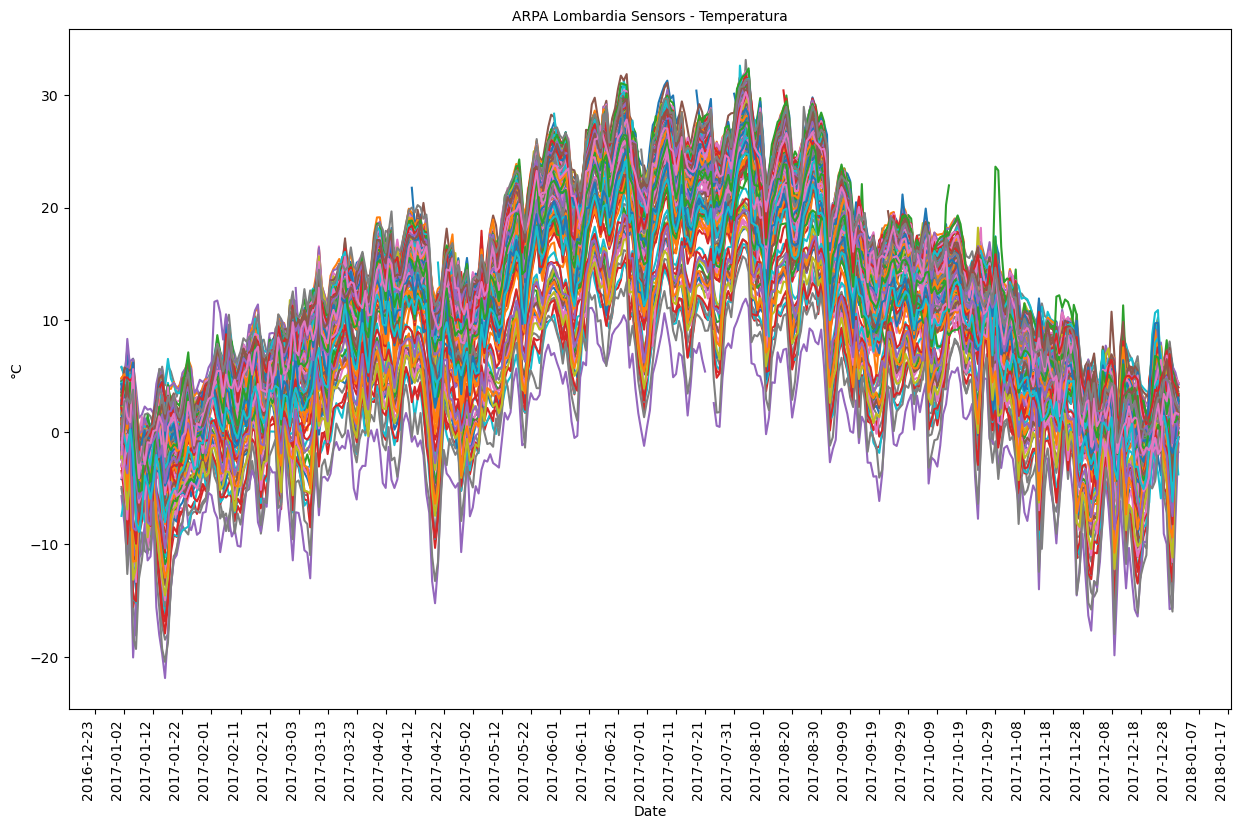

In [31]:
# Create a new figure
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title('ARPA Lombardia Sensors - '+ sensor_sel,fontdict = {'fontsize': 10})
ax.set_ylabel(measure_unit,fontdict = {'fontsize': 10})
ax.set_xlabel('Date',fontdict = {'fontsize': 10})
# Iterate over the sensor IDs
for sensor_id in sensors_list:
    # Get the data for the current sensor
    sensor_data = merged_df[merged_df['idsensore'] == sensor_id]
    # Plot the time series for the sensor
    ax.plot(sensor_data['data'], sensor_data['valore'], label=sensor_id)

# # Add a legend to the plot
# ax.legend()

# Show the plot
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate()
plt.xticks(rotation=90)
plt.show()

In [32]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also

#   print(sel_sensor_min)
#     print(merged_df.loc[merged_df['idsensore'] == 17573])

### Check highest and lowest values

Select the sensor that provide the lowest value in the dataframe to check if there are possible errors:

In [33]:
min_index = merged_df['valore'].idxmin()
idsensor_min = merged_df.loc[min_index].idsensore
sel_sensor_min = merged_df.loc[merged_df['idsensore']==idsensor_min]
data_min = merged_df.loc[min_index]['data']
merged_df.loc[min_index]

idsensore                                                    14221
data                                           2017-01-16 00:00:00
valore                                                  -21.901981
tipologia                                              Temperatura
unit_dimisura                                                   °C
idstazione                                                    1343
nomestazione                               Lanzada Passo Marinelli
quota                                                         3032
provincia                                                       SO
datastart                                      2012-10-13 00:00:00
storico                                                          N
cgb_nord                                                   5133321
cgb_est                                                     570414
lng                                              9.915147774061634
lat                                              46.3498020502

Select the sensor that provide the highest value in the dataframe:

In [34]:
max_index = merged_df['valore'].idxmax()
idsensor_max = merged_df.loc[max_index].idsensore
sel_sensor_max = merged_df.loc[merged_df['idsensore']==idsensor_max]
data_max = merged_df.loc[max_index]['data']
merged_df.loc[max_index]

idsensore                                                    17001
data                                           2017-08-04 00:00:00
valore                                                   33.146152
tipologia                                              Temperatura
unit_dimisura                                                   °C
idstazione                                                    1303
nomestazione                                Cremona v.Gerre Borghi
quota                                                           36
provincia                                                       CR
datastart                                      2011-10-10 00:00:00
storico                                                          N
cgb_nord                                                   4995675
cgb_est                                                     584111
lng                                             10.069230734956498
lat                                              45.1095393802

In [35]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(sel_sensor_max)

Plot min and max selected sensors:

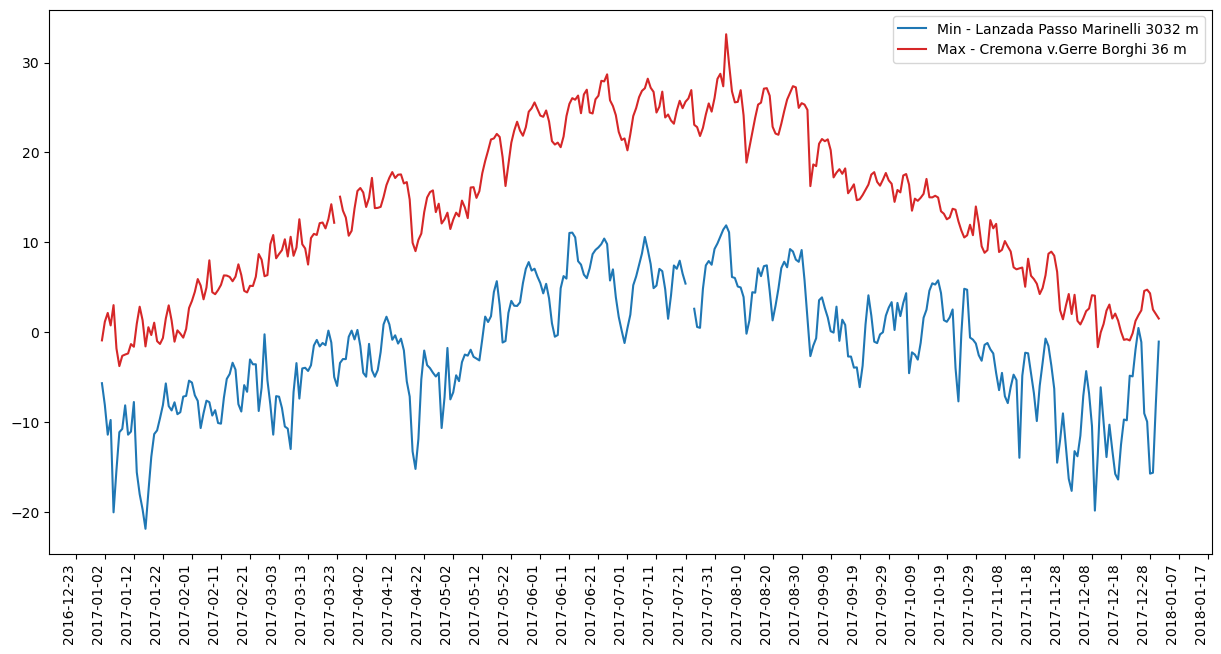

In [36]:
plt.figure(figsize=(15,8))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate()
plt.xticks(rotation=90)
plt.plot(sel_sensor_min['data'],sel_sensor_min['valore'], '-',  color="tab:blue", label=("Min - {nome} {quota} m").format(nome=sel_sensor_min["nomestazione"].unique()[0], quota=sel_sensor_min["quota"].unique()[0]))
plt.plot(sel_sensor_max['data'],sel_sensor_max['valore'], '-',  color="tab:red", label=("Max - {nome} {quota} m").format(nome=sel_sensor_max["nomestazione"].unique()[0], quota=sel_sensor_max["quota"].unique()[0]))
plt.legend()

### Box Plot

Text(1, 35.14615249633789, 'ID: 14221, Quota: 3032 m\n Lanzada Passo Marinelli')

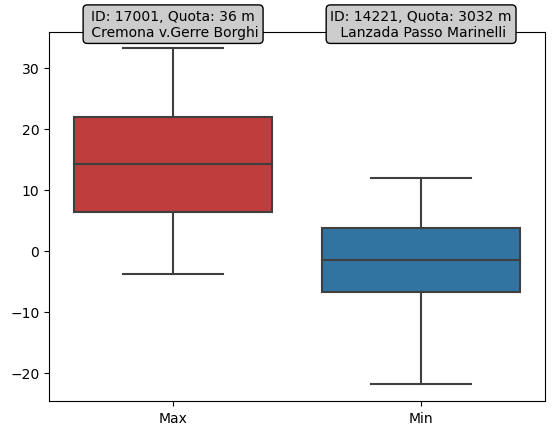

In [37]:
my_pal = {0: "tab:red", 1: "tab:blue"}
box = sns.boxplot(data=[sel_sensor_max['valore'], sel_sensor_min['valore']], orient="v", palette=my_pal)
plt.xticks([0, 1],["Max","Min"])
box.annotate(("ID: {id}, Quota: {quota} m\n {nome}").format(id=sel_sensor_max["idsensore"].unique()[0],
             quota=sel_sensor_max["quota"].unique()[0], nome=sel_sensor_max["nomestazione"].unique()[0]),
             xy=(0, sel_sensor_max['valore'].max()+2),
             horizontalalignment='center',
             bbox=dict(boxstyle="round", fc="0.8"))
box.annotate(("ID: {id}, Quota: {quota} m\n {nome}").format(id=sel_sensor_min["idsensore"].unique()[0],
             quota=sel_sensor_min["quota"].unique()[0], nome=sel_sensor_min["nomestazione"].unique()[0]),
             xy=(1, sel_sensor_max['valore'].max()+2),
             horizontalalignment='center',
             bbox=dict(boxstyle="round", fc="0.8"))

### Map

In [38]:
import matplotlib.pyplot as plt
import geopandas as gpd 
from shapely.geometry import box
from scipy.interpolate import griddata

Import Lombardy and CMM vector files:

In [39]:
lombardy_gdf = gpd.read_file('lombardia_boundary.gpkg')
cmm_gdf = gpd.read_file('CMM.gpkg')

Convert to Geodataframe:

In [40]:
gdf = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df.cgb_est, merged_df.cgb_nord), crs="EPSG:32632")

Filter on the dates corresponding to the max and min values found before:

In [41]:
min_date = merged_df.loc[min_index].data
max_date =merged_df.loc[max_index].data

In [42]:
min_date, max_date

(Timestamp('2017-01-16 00:00:00'), Timestamp('2017-08-04 00:00:00'))

In [43]:
max_gdf = gdf.loc[merged_df['data'] == max_date]
min_gdf = gdf.loc[merged_df['data'] == min_date]

In [44]:
min_point = min_gdf.loc[min_gdf['idsensore'] == idsensor_min]
max_point = max_gdf.loc[max_gdf['idsensore'] == idsensor_max]

Text(0.5, 173.14773259505725, 'East [m]')

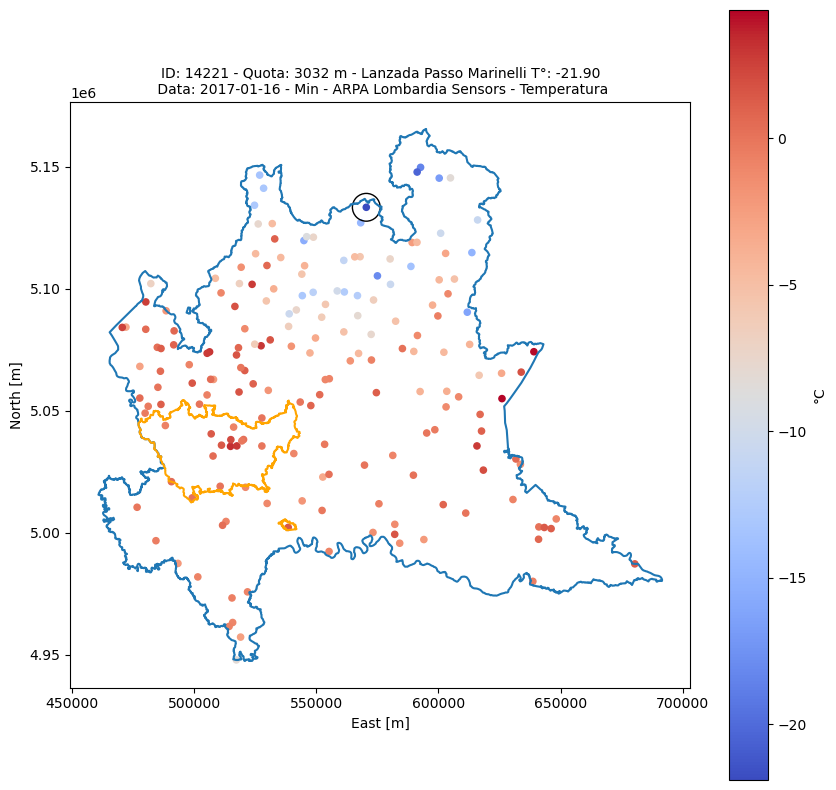

In [45]:
fig, ax = plt.subplots(figsize = (10,10))
min_gdf.plot(ax=ax, markersize=20, column='valore', legend=True, cmap='coolwarm', legend_kwds={'label': measure_unit ,'orientation': "vertical"});
lombardy_gdf.boundary.plot(ax=ax);
cmm_gdf.boundary.plot(ax=ax, edgecolor='orange');
min_point.plot(ax=ax, marker='o', markersize=400, color='black',facecolors='none')
ax.set_title(("ID: {id} - Quota: {quota} m - {nome} T°: {minT:0.2f}\n Data: {data} - Min - ARPA Lombardia Sensors - {sensor_sel}").format(id=sel_sensor_min["idsensore"].unique()[0],
             quota=sel_sensor_min["quota"].unique()[0], nome=sel_sensor_min["nomestazione"].unique()[0], minT=sel_sensor_min['valore'].min(),
             data=data_min.strftime("%Y-%m-%d"), sensor_sel=sensor_sel), fontdict = {'fontsize': 10})
ax.set_ylabel('North [m]',fontdict = {'fontsize': 10})
ax.set_xlabel('East [m]',fontdict = {'fontsize': 10})

Text(0.5, 173.14773259505725, 'East [m]')

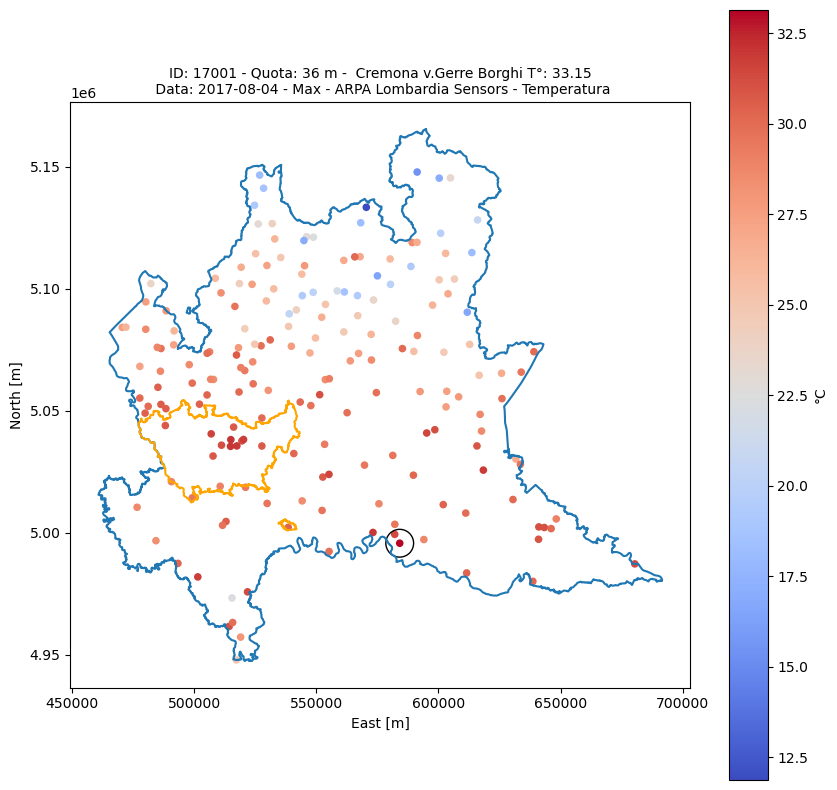

In [46]:
fig, ax = plt.subplots(figsize = (10,10))
max_gdf.plot(ax=ax, markersize=20, column='valore', legend=True, cmap='coolwarm', legend_kwds={'label': measure_unit ,'orientation': "vertical"});
lombardy_gdf.boundary.plot(ax=ax);
cmm_gdf.boundary.plot(ax=ax, edgecolor='orange');
max_point.plot(ax=ax, marker='o', markersize=400, color='black',facecolors='none')
ax.set_title(("ID: {id} - Quota: {quota} m -  {nome} T°: {maxT:0.2f}\n Data: {data} - Max - ARPA Lombardia Sensors - {sensor_sel}").format(id=sel_sensor_max["idsensore"].unique()[0],
             quota=sel_sensor_max["quota"].unique()[0], nome=sel_sensor_max["nomestazione"].unique()[0], maxT=sel_sensor_max['valore'].max(),
             data=data_max.strftime("%Y-%m-%d"), sensor_sel=sensor_sel), fontdict = {'fontsize': 10})

ax.set_ylabel('North [m]',fontdict = {'fontsize': 10})
ax.set_xlabel('East [m]',fontdict = {'fontsize': 10})

Text(0.5, 173.14773259505725, 'East [m]')

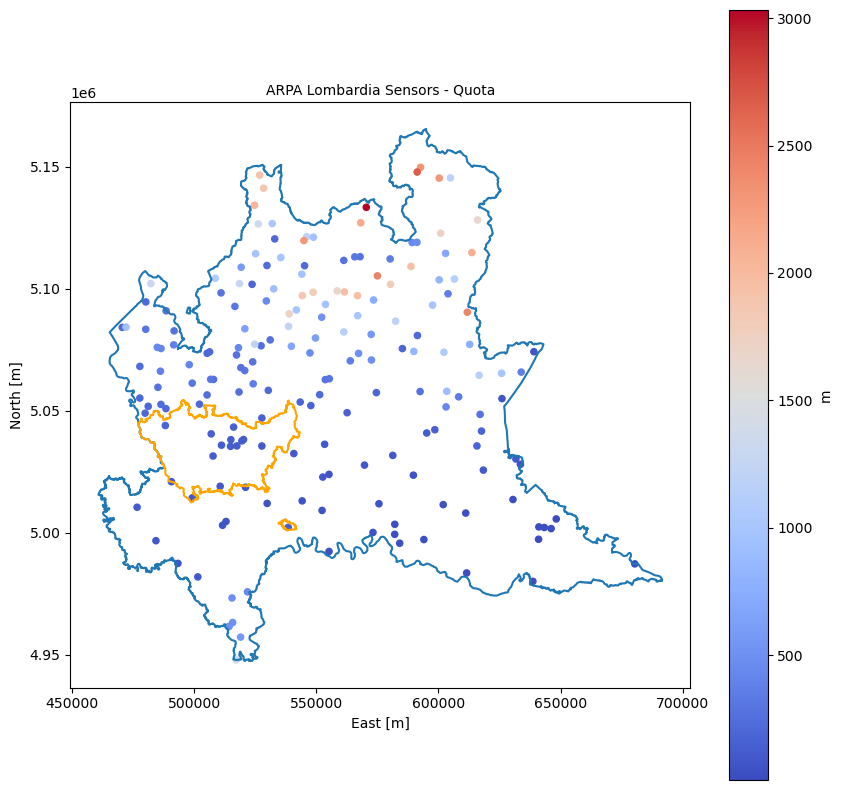

In [47]:
fig, ax = plt.subplots(figsize = (10,10))
max_gdf.plot(ax=ax, markersize=20, column='quota', legend=True, cmap='coolwarm', legend_kwds={'label': 'm' ,'orientation': "vertical"});
lombardy_gdf.boundary.plot(ax=ax);
cmm_gdf.boundary.plot(ax=ax, edgecolor='orange');
ax.set_title('ARPA Lombardia Sensors - Quota',fontdict = {'fontsize': 10})
ax.set_ylabel('North [m]',fontdict = {'fontsize': 10})
ax.set_xlabel('East [m]',fontdict = {'fontsize': 10})

In [48]:
gdf_test = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df.lng, merged_df.lat), crs="EPSG:4326")

In [49]:
gdf_test.dtypes

idsensore                 int64
data             datetime64[ns]
valore                  float32
tipologia              category
unit_dimisura            object
idstazione                int32
nomestazione             object
quota                     int16
provincia              category
datastart        datetime64[ns]
storico                category
cgb_nord                 object
cgb_est                  object
lng                      object
lat                      object
location                 object
datastop         datetime64[ns]
geometry               geometry
dtype: object

In [50]:
gdf_test

,idsensore,data,valore,tipologia,unit_dimisura,idstazione,nomestazione,quota,provincia,datastart,storico,cgb_nord,cgb_est,lng,lat,location,datastop,geometry
0,115,2017-01-01,-1.532639,Temperatura,°C,58,Carona Lago Fregabolgia,1955,BG,2001-12-01,N,5097125,566799,9.863057198828766,46.02443987306136,"{'latitude': '46.02443987306136', 'longitude':...",NaT,POINT (9.86306 46.02444)
1,12025,2017-01-01,-2.091667,Temperatura,°C,1297,Spinadesco v.Battisti,48,CR,2011-02-03,N,5000087,573153,9.930596472272326,45.150468869856816,"{'latitude': '45.150468869856816', 'longitude'...",NaT,POINT (9.93060 45.15047)
2,14014,2017-01-01,2.479167,Temperatura,°C,1077,Oltre il Colle Zambla,1138,BG,2012-01-13,N,5082261,561209,9.78893967466926,45.891193045896635,"{'latitude': '45.891193045896635', 'longitude'...",NaT,POINT (9.78894 45.89119)
3,4001,2017-01-01,-1.493750,Temperatura,°C,140,Motta Visconti SMR,100,MI,2003-05-23,S,5014273,499103,8.988562726793255,45.281956197427846,"{'latitude': '45.281956197427846', 'longitude'...",2020-08-25,POINT (8.98856 45.28196)
4,14058,2017-01-01,5.736805,Temperatura,°C,1324,Limone sul Garda,75,BS,2012-03-13,N,5074143,639088,10.790041404031163,45.80682631535527,"{'latitude': '45.80682631535527', 'longitude':...",NaT,POINT (10.79004 45.80683)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69668,5863,2017-12-31,1.795833,Temperatura,°C,595,Filago v.Don Milani,190,BG,1991-12-07,N,5053519,543342,9.556084255790864,45.63386450908066,"{'latitude': '45.63386450908066', 'longitude':...",NaT,POINT (9.55608 45.63386)
69669,9025,2017-12-31,1.150000,Temperatura,°C,1228,Goito,30,MN,2004-03-11,N,5013581,630514,10.663595357934602,45.2636105457828,"{'latitude': '45.2636105457828', 'longitude': ...",NaT,POINT (10.66360 45.26361)
69670,9026,2017-12-31,2.147917,Temperatura,°C,1233,Lurago Marinone,296,CO,2004-01-01,N,5061268,499092,8.98833547049708,45.704965032524214,"{'latitude': '45.704965032524214', 'longitude'...",NaT,POINT (8.98834 45.70497)
69671,5865,2017-12-31,1.977778,Temperatura,°C,596,Osio Sotto v.per Levate,182,BG,2000-04-04,N,5052072,547691,9.611737821812373,45.62055567939559,"{'latitude': '45.62055567939559', 'longitude':...",NaT,POINT (9.61174 45.62056)


In [84]:
min_gdf["lat"] = [float(str(i).replace(",", "")) for i in min_gdf["lat"]]

In [85]:
min_gdf["lng"] = [float(str(i).replace(",", "")) for i in min_gdf["lng"]]

In [87]:
#using plotly for an animated choropleth map
import plotly.express as px
fig = px.scatter_mapbox(min_gdf,
                        lat="lat",
                        lon="lng",
                        hover_name="idsensore",
                        hover_data=["valore"],
                        color="valore",
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        zoom=7,
                        height=600,
                        size='lat',
                        size_max=12,
                        opacity=1,
                        width=900)
fig.update_layout(mapbox_style='carto-darkmatter')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

Interactive map (use a small geodataframe)

In [54]:
# gdf_test = gdf
# gdf_test['data'] = gdf_test['data'].astype(str)
# gdf_test = gdf_test.drop(['datastart','datastop'], axis=1)
# m = gdf_test.explore(
#      column="valore",  # make choropleth based on "BoroName" column
#      cmap='OrRd',
#      scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
#      legend=True, # show legend
#      k=10, # use 10 bins
#      legend_kwds=dict(colorbar='OrRd'), # do not use colorbar
#      name="stations") # name of the layer in the map

# lombardy_gdf.explore(m=m,
#                     style_kwds=dict(fill=False))

## Other useful functions

In [55]:
# def remove_csv_file(filename):
#     if os.path.exists(filename):
#         print("Csv file removed from folder")
#         os.remove(filename)
#     else:
#         print("The file does not exist")

In [56]:
# remove_csv_file(csv_file)

In [57]:
# from scipy import stats

# def zscore_filter(df, zscore_tr=3):

#     grouped = df.groupby('idsensore')
    
#     # for each group, calculate the z-scores and remove the outliers
#     for name, group in grouped:
#         df['z_scores'] = stats.zscore(group['valore'], nan_policy='omit')
#         df = df[(df['idsensore'] != name) | (df['z_scores'].abs() <= zscore_tr)]
 
#     return df

In [58]:
# # backup 
#     #Create list of sensor integer
#     sens_list = list(map(int, sens_list_str))
    
#     #Create sensors list formatted for query
#     ids_str = ""
#     for i in sens_list:
#         ids_str += f"\'{str(i)}\',"
#     ids_str = ids_str[:-1]
#     ids_str += ""
    
#     #Select the Open Data Lombardia Meteo sensors dataset
#     weather_sensor_id = "647i-nhxk"
    
#     #Convert to string in year-month-day format, accepted by ARPA query
#     start_date = start_date.strftime("%Y-%m-%dT%H:%M:%S.%f")
#     end_date = end_date.strftime("%Y-%m-%dT%H:%M:%S.%f")
    
#     print("--- Starting request to ARPA API ---")
    
#     t = time.time()
    
#     #Query data
#     query = """
#       select
#           *
#       where data >= \'{}\' and data <= \'{}\' and idsensore in ({}) limit 9999999999999999
#       """.format(start_date, end_date, ids_str)